In [3]:
import os

# List files and directories in the root directory
root_directory = '/content/'
all_files = os.listdir(root_directory)
all_files

['.config', 'sample_data']

In [4]:
import shutil

# Function to delete all files and directories in the specified directory
def delete_all_in_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
                print(f"Deleted file {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Deleted directory {file_path}")
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Delete all files and directories in the root directory
delete_all_in_directory(root_directory)


Deleted directory /content/.config
Deleted directory /content/sample_data


In [5]:
import zipfile
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import numpy as np
import pandas as pd
import csv

In [6]:
# Download the dataset
!wget -O train_images.zip https://zenodo.org/records/10821435/files/train_images.zip?download=1

# Extract the dataset
!unzip train_images.zip -d train_images

# Verify the extraction
!ls train_images

Streaming output truncated to the last 5000 lines.
  inflating: train_images/train/ROCOv2_2023_train_055141.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055142.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055143.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055144.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055145.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055146.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055147.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055148.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055149.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055150.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055151.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055152.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055153.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055154.jpg  
  inflating: train_images/train/ROCOv2_2023_train_055155.jpg  
  in

In [7]:
# Download the dataset
!wget -O test_images.zip https://zenodo.org/records/10821435/files/test_images.zip?download=1

# Extract the dataset
!unzip test_images.zip -d test_images

# Verify the extraction
!ls test_images

Streaming output truncated to the last 5000 lines.
  inflating: test_images/test/ROCOv2_2023_test_004947.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004948.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004949.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004950.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004951.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004952.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004953.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004954.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004955.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004956.jpg  
 extracting: test_images/test/ROCOv2_2023_test_004957.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004958.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004959.jpg  
  inflating: test_images/test/ROCOv2_2023_test_004960.jpg  
 extracting: test_images/test/ROCOv2_2023_test_004961.jpg  
  inflating: test_images/test/ROCOv2_2023_test_00

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir , feature_extractor):
        self.image_dir = image_dir
        self.feature_extractor = feature_extractor
        # Get a list of all image files in the directory
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        inputs = self.feature_extractor(images=image, return_tensors="pt")

        # Extract the corresponding label from the CSV
        image_file_name = os.path.basename(img_path)

        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'noise': None,  # Add other keys as necessary, using None or default values if not applicable
            'head_mask': None,
            'output_attentions': None,
            'output_hidden_states': None,
            'return_dict': None,
            'interpolate_pos_encoding': None,
            'label_ids': None,
            'labels': None  # Return the label along with the pixel values
        }

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
image_dir_train = '/content/train_images/train'
image_dir_test = '/content/test_images/test'

In [11]:
train_dataset = CustomImageDataset(image_dir=image_dir_train,  feature_extractor=feature_extractor)
test_dataset = CustomImageDataset(image_dir=image_dir_test,  feature_extractor=feature_extractor)

In [15]:
print(len(test_dataset))  # Check if the dataset is empty

9927


In [16]:
print(len(train_dataset))  # Check if the dataset is empty

59958


In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.192300,No log
2,0.186600,No log


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 195919744 vs 195919636

In [23]:
trainer.save_model("./finetuned-vit-mae")

part 4 :

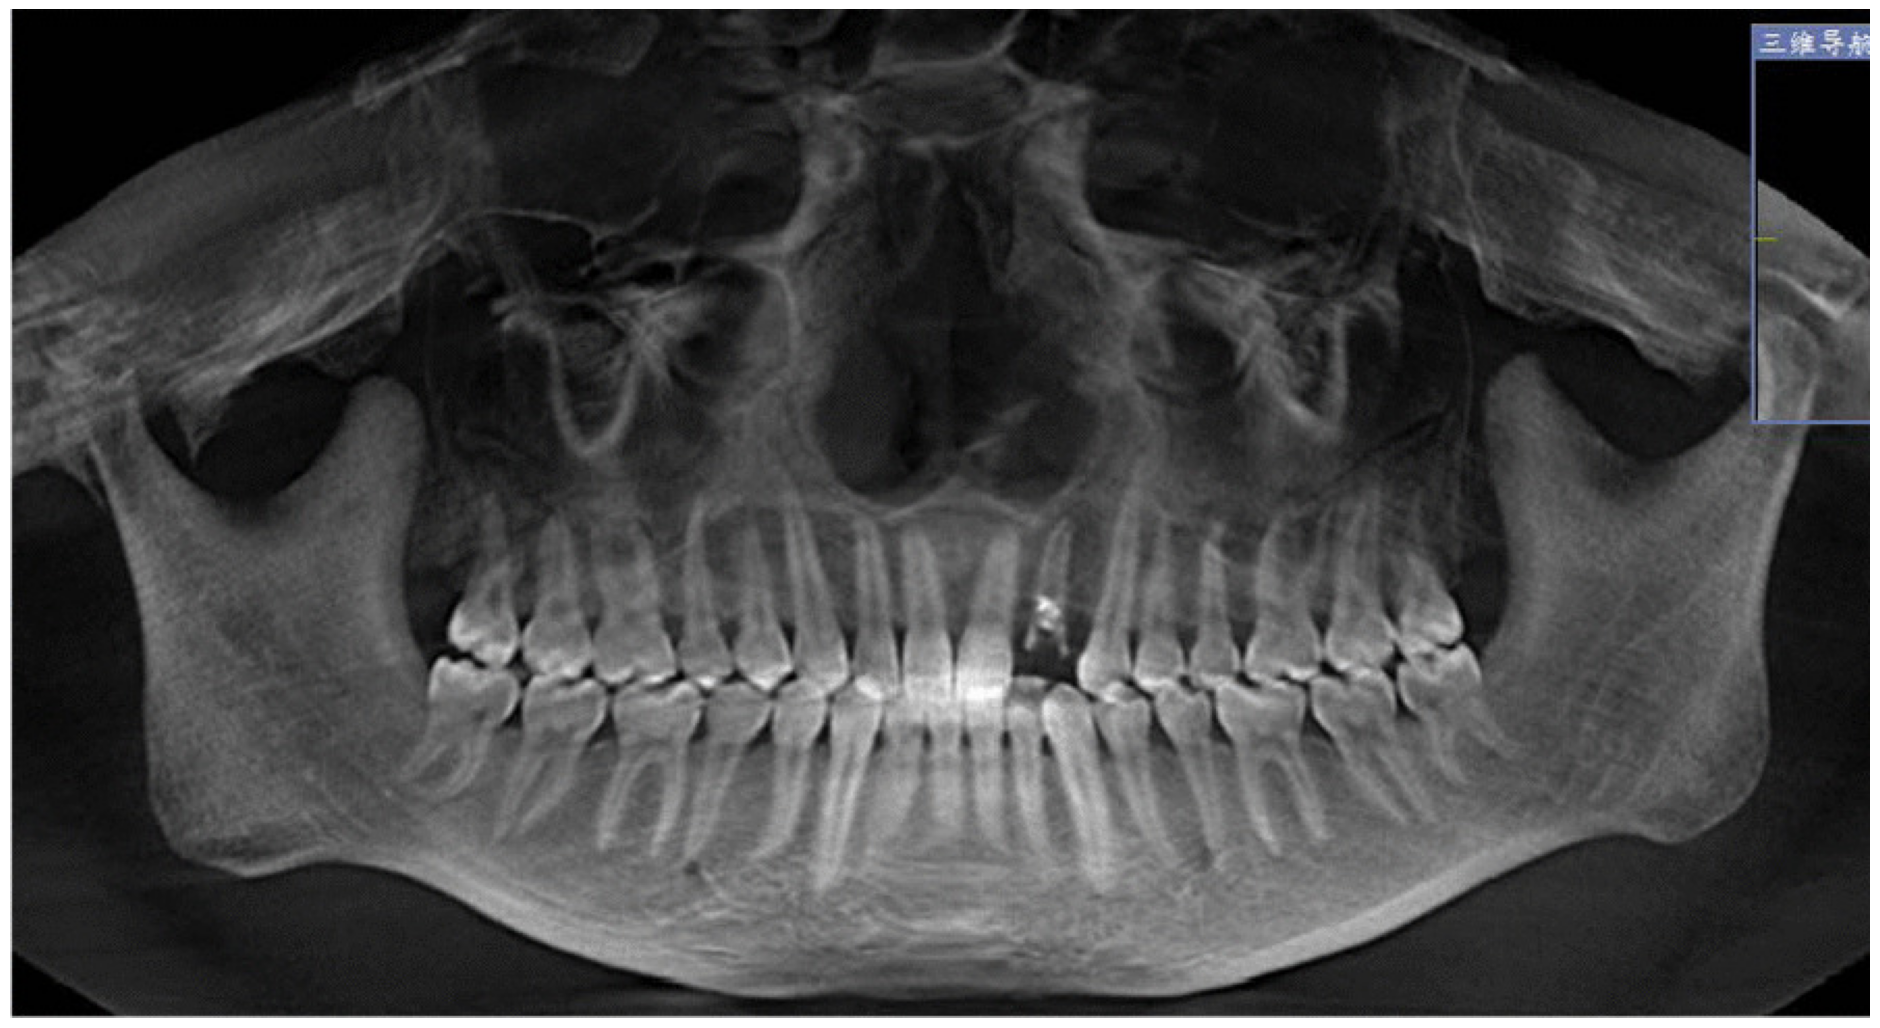

In [38]:
dataset_dir = '/content/test_images/test'
all_files = os.listdir(dataset_dir)
selected_files = random.sample(all_files, 1)

for image_file in selected_files:
    img_path = os.path.join(dataset_dir, image_file)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [39]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(img, title=''):
    # image is [H, W, 3]
    assert img.shape[2] == 3
    plt.imshow(torch.clip((img * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    x = torch.einsum('nchw->nhwc', pixel_values)
    # masked image
    im_masked = x * (1 - mask)
    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    plt.rcParams['figure.figsize'] = [24, 24]
    plt.subplot(1, 4, 1)
    show_image(x[0], "original")
    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")
    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")
    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")
    plt.show()


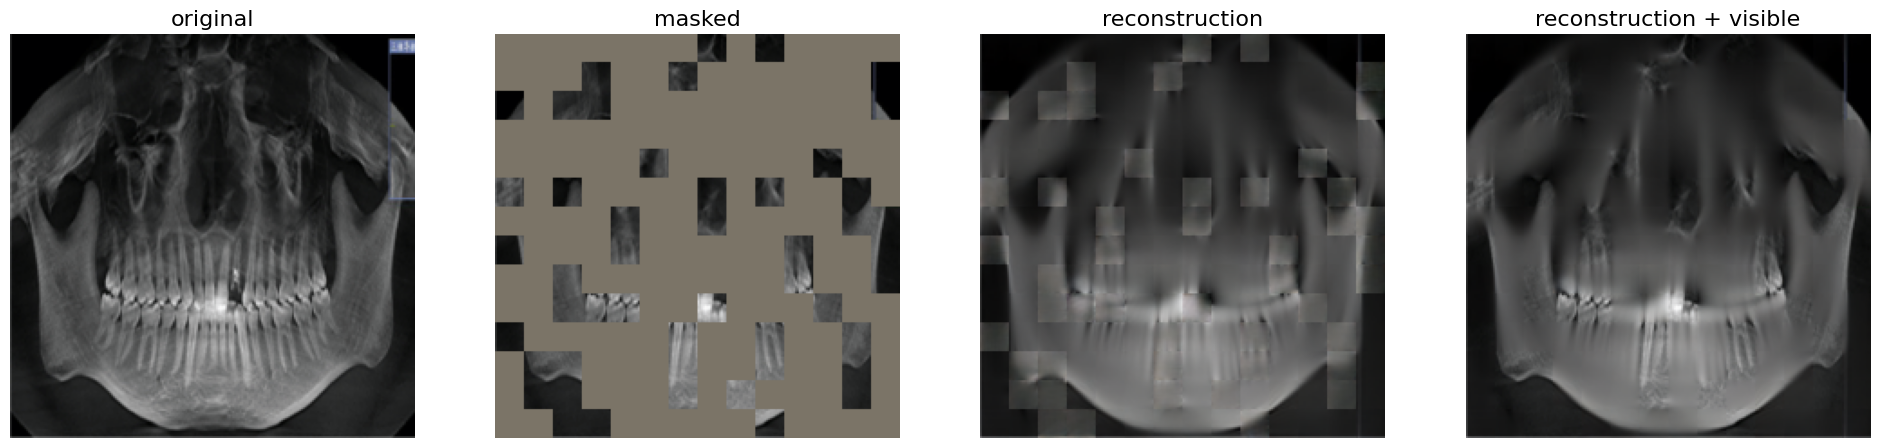

In [41]:
from transformers import ViTMAEForPreTraining

torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("./finetuned-vit-mae")

visualize(pixel_values, model)
